In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
from scipy.stats import chi2
import os
import Optimization_function as opt
import copy

## Data Input and Parameters Setting

In [2]:
path = 'Data/backtest'
etf_price = pd.DataFrame(data = None)
col_name = []
for file in os.listdir(path):
    temp_df = pd.read_csv(path+'/'+file,index_col = 0)
    etf_price = etf_price.join(temp_df['Adj Close'], how = 'outer', rsuffix = '_'+file.replace('.csv',''))
    col_name.append(file.replace('.csv',''))
etf_price.columns = col_name

In [3]:
etf_price.head()

,DBC,GLD,SHY,SPIB,VB,VGLT,VO,VOO,VWO
Date,,,,,,,,,
2011-01-01,27.720127,129.869995,77.223198,24.846546,63.606075,45.028736,66.293297,97.050125,36.284428
2011-02-01,28.876345,137.660004,77.067108,24.854103,67.119446,45.659843,69.029724,100.414337,36.221985
2011-03-01,29.643923,139.860001,76.973221,24.754948,68.693520,45.608601,70.197540,99.969070,38.204388
2011-04-01,30.994463,152.369995,77.378723,25.200146,70.716682,46.604511,72.111229,103.365273,39.492184
2011-05-01,29.391300,149.639999,77.661613,25.463169,69.333832,48.164551,71.806122,102.156036,38.329273


In [4]:
etf_rtn = etf_price.pct_change()[1:]

In [5]:
window_length = 60 #Set 5 years as the window length to calculate parameters
#t = 10 #Set risk tolerance parameter
eta = 0.95 #Set confidence level

## Optimization Implementation

In [18]:
def optimization_implementation(return_df, window_length, eta, target_risk, t, method = 'target risk'):
    portfolio_return = pd.DataFrame(data = None, index = return_df.index[window_length:], columns = ['mean_variance', 'robust'])
    mv_weight = pd.DataFrame(data = None, index = return_df.index[window_length:], columns = col_name)
    robust_weight = pd.DataFrame(data = None, index = return_df.index[window_length:], columns = col_name)
    
    for i in range(len(return_df) - window_length):
        sample_mean = return_df.iloc[i:(i+window_length),:].mean().values
        sample_cov = return_df.iloc[i:(i+window_length),:].cov().values
        sigma = np.diag(np.diag(sample_cov))/window_length
        
        if method == 'target risk':
            risk_level = target_risk/np.sqrt(12)
            w1 = opt.Markovitz_opt_risktarget(sample_mean, sample_cov, risk_level)
            r1 = np.dot(w1.T, return_df.iloc[(i+window_length),:].values)[0]
            
            w2 = opt.Robust_opt_risktarget(sample_mean, sample_cov, sigma, eta, risk_level)
            r2 = np.dot(w2.T, return_df.iloc[(i+window_length),:].values)[0]
        
        elif method == 'global':
            w1 = opt.Markovitz_opt(sample_mean, sample_cov, t)
            r1 = np.dot(w1.T, return_df.iloc[(i+window_length),:].values)[0]
    
            w2 = opt.Robust_opt(sample_mean, sample_cov, sigma, t, eta)
            r2 = np.dot(w2.T, return_df.iloc[(i+window_length),:].values)[0]
    
        portfolio_return.iloc[i, 0] = r1
        portfolio_return.iloc[i, 1] = r2
            
        mv_weight.iloc[i, :] = w1.T
        robust_weight.iloc[i, :] = w2.T
        
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4))
    mv_weight.plot(kind = 'area', ax = axes[0], title = 'Asset weights under Markowitz mean-variance optimization')
    robust_weight.plot(kind = 'area', ax = axes[1], title = 'Asset weights under Robust optimization')
        
    portfolio_return_plt = copy.copy(portfolio_return)
    portfolio_return_plt.loc[return_df.index[window_length]] = 0.0
    (portfolio_return_plt+1).cumprod().plot(ax = axes[2], title = 'Return Comparison')
        
    portfolio_eval = portfolio_evaluation(portfolio_return, risk_free_rate = 0.0)
        
    return portfolio_eval 

In [19]:
def portfolio_evaluation(portfolio_performance, risk_free_rate = 0.0):
    portfolio_evaluation = pd.DataFrame(data = None, index = portfolio_performance.columns)
    
    annual_rtn = pd.DataFrame(portfolio_performance.mean()*12)
    annual_rtn.columns = ['annualized return']
    annual_vol = pd.DataFrame(portfolio_performance.std()*np.sqrt(12))
    annual_vol.columns = ['annualized volatility']
    
    excess_rtn = portfolio_performance - risk_free_rate
    Sharpe_ratio = pd.DataFrame(excess_rtn.mean()*12/(excess_rtn.std()*np.sqrt(12)))
    Sharpe_ratio.columns = ['Sharpe ratio']
    
    cumulative_r = (portfolio_performance+1).cumprod()
    dd = 1-cumulative_r/cumulative_r.expanding(min_periods=1).max()
    MDD = pd.DataFrame(dd.max(axis = 0))
    MDD.columns = ['maximum drawdown']
    
    portfolio_evaluation = portfolio_evaluation.join(annual_rtn)
    portfolio_evaluation = portfolio_evaluation.join(annual_vol)
    portfolio_evaluation = portfolio_evaluation.join(Sharpe_ratio)
    portfolio_evaluation = portfolio_evaluation.join(MDD)
    
    return portfolio_evaluation

### Results Comparison: different risk tolerance parameter

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.109352,0.137088,0.797682,0.199094
robust,0.065139,0.052866,1.232161,0.065239


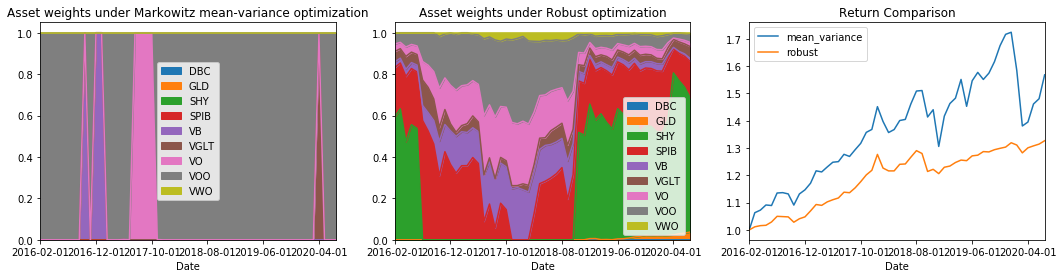

In [20]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = None, t = 10, method = 'global')

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.109102,0.137078,0.795910,0.199094
robust,0.065800,0.053503,1.229833,0.066435


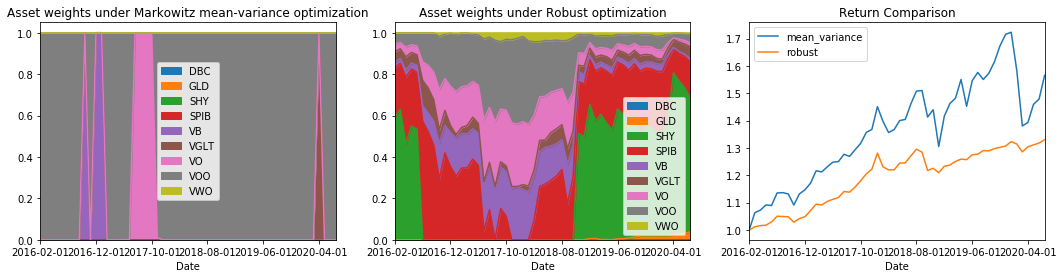

In [21]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = None, t = 50, method = 'global')

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.109137,0.137083,0.796140,0.199094
robust,0.065898,0.053588,1.229715,0.066594


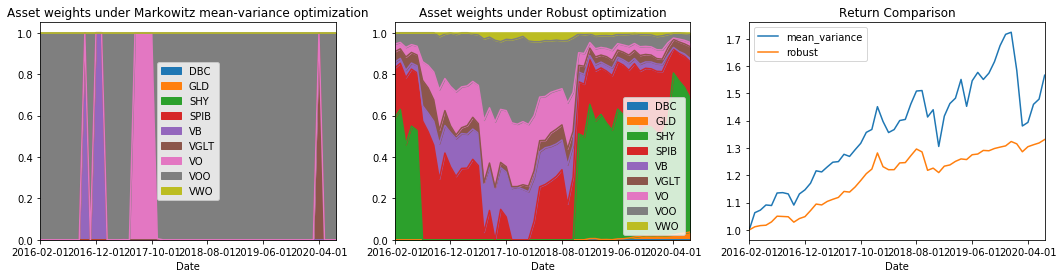

In [22]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = None, t = 100, method = 'global')

### Results Comparison: different target risk level

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.027391,0.012131,2.257907,0.007143
robust,0.026104,0.012015,2.172608,0.006767


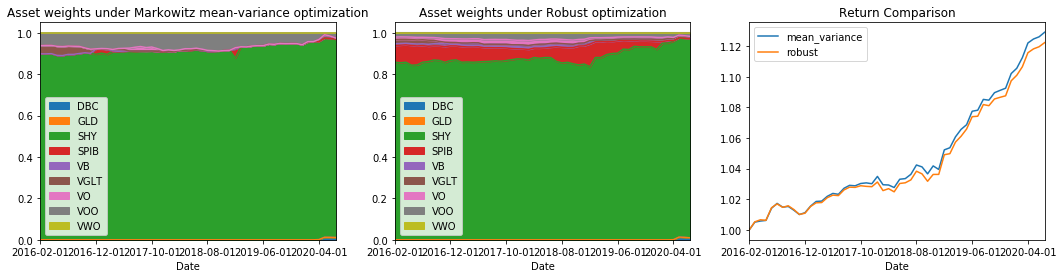

In [29]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = 0.01, t = None, method = 'target risk')

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.048927,0.045381,1.078147,0.066720
robust,0.040950,0.029185,1.403103,0.033913


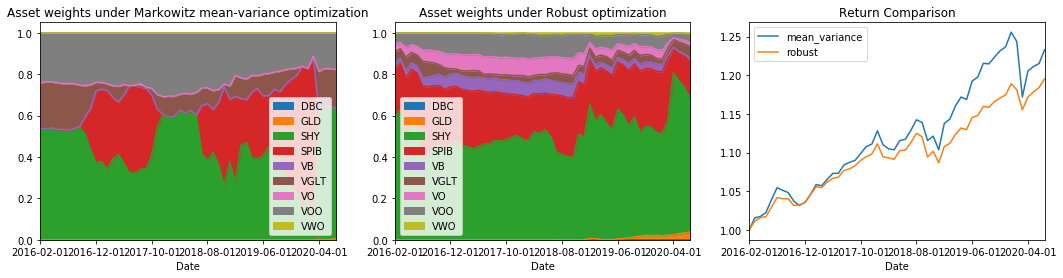

In [23]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = 0.03, t = None, method = 'target risk')

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.083416,0.061919,1.347176,0.066881
robust,0.050484,0.039108,1.290892,0.052777


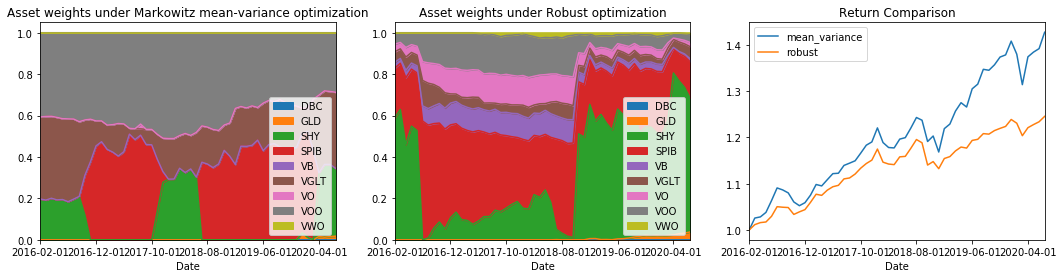

In [24]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = 0.05, t = None, method = 'target risk')

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.122673,0.091334,1.343132,0.103789
robust,0.062021,0.050045,1.239308,0.066795


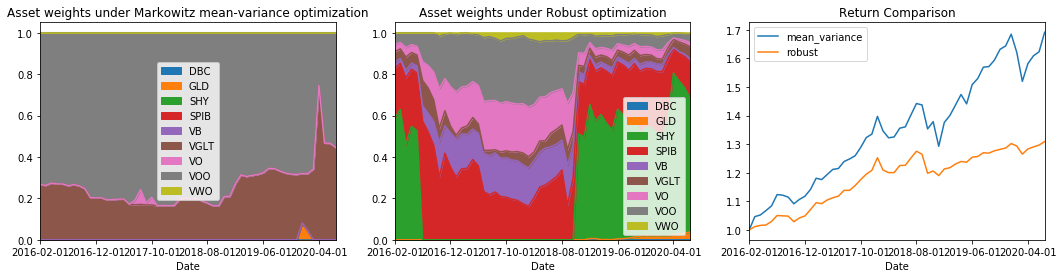

In [25]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = 0.08, t = None, method = 'target risk')

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.121236,0.117032,1.035919,0.149322
robust,0.065748,0.053480,1.229387,0.066772


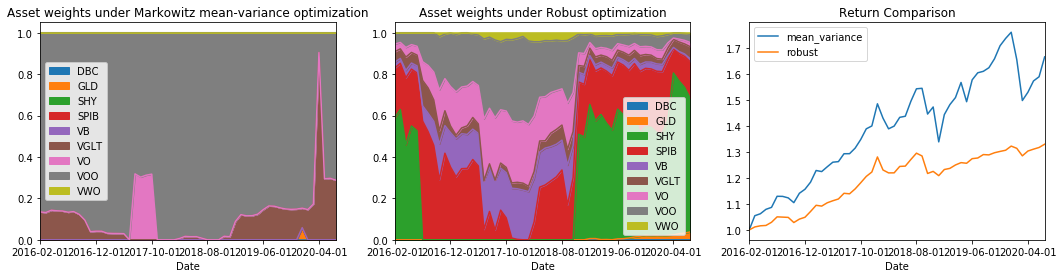

In [27]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = 0.10, t = None, method = 'target risk')

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.109069,0.137062,0.795763,0.199093
robust,0.066001,0.053675,1.229645,0.066766


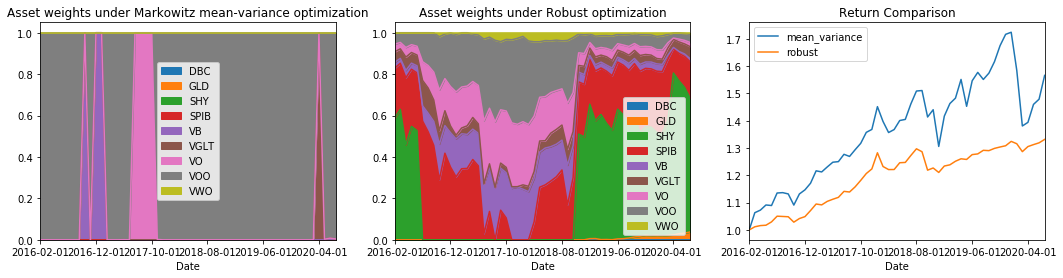

In [28]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = 0.15, t = None, method = 'target risk')